# Likelihood MP2RAGE
We use the relative likelihood to determine the value of T1.

In [4]:
import os
import json
import nibabel as nib
from nilearn import plotting
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from sklearn.metrics import mean_squared_error
import t1_mapping
from adam_utils.nifti import plot_nifti
from scipy.interpolate import RegularGridInterpolator

# Change plot style
plt.style.use('Solarize_Light2')

# Load data
We load the given data from an example MP2RAGE sequence.

In [5]:
# Load subject
subj = t1_mapping.mp2rage.MP2RAGESubject(
    subject_id='334264',
    scan='401-x-WIPMP2RAGE_0p7mm_1sTI_best_oneSENSE-x-WIPMP2RAGE_0p7mm_1sTI_best_oneSENSE',
    scan_times=['1010', '3310', '5610']
    )

## Plot T1-weighted image
Now, we plot the T1-weighted image calculated from the gradient echo readouts.

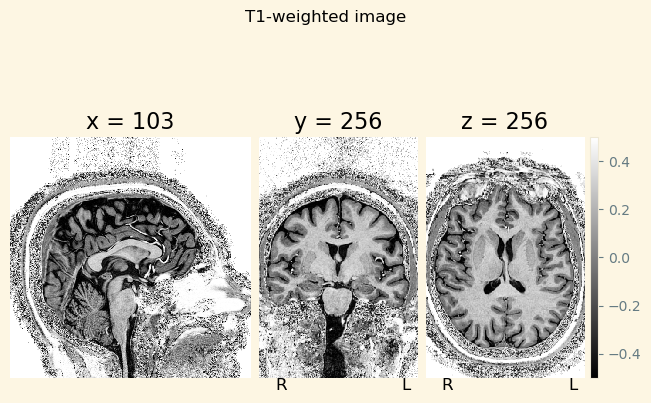

In [6]:
# Plot T1-weighted image
fig, ax = plot_nifti(subj.t1w, title='T1-weighted image')
plt.show()

# Load Monte Carlo distribution
Next, we load the results from our Monte Carlo distribution that modeled how to calculate MP2RAGE images if there were some Gaussian noise ($\sigma^2=0.005$) in the gradient echo readouts. This simulation ran for 100 million trials.

In [7]:
# Load NumPy array for counts
counts = np.load(os.path.join(t1_mapping.definitions.SIMULATION_DATA, 'counts_100M_spacing.npy'))

## Calculate ideal MP2RAGE equations

In [8]:
# Range of values for T1
delta_t1 = subj.delta_t1
t1_estimate = subj.t1

# Calculate what values would be produced using these parameters
GRE = t1_mapping.utils.gre_signal(T1=t1_estimate, **subj.eqn_params)

# Calculate what MP2RAGE image would have been
mp2rage1 = t1_mapping.utils.mp2rage_t1w(GRE[0,:], GRE[1,:])
mp2rage2 = t1_mapping.utils.mp2rage_t1w(GRE[0,:], GRE[2,:])

delta_m = subj.delta_m

## Plot MP2RAGE equations

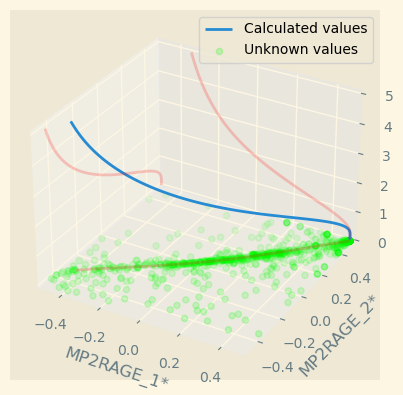

In [9]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Plot curve of known values
ax.plot(mp2rage1, mp2rage2, t1_estimate, label='Calculated values')
ax.set_xlabel('MP2RAGE_1*')
ax.set_ylabel('MP2RAGE_2*')
ax.set_zlabel('T1 (s)')
ax.set(xlim=(-0.5, 0.5), ylim=(-0.5, 0.5), zlim=(0,5))

# Plot values we want to calculate
t1w1 = subj.mp2rage[0].get_fdata()
t1w2 = subj.mp2rage[1].get_fdata()
indx = np.arange(0, len(t1w1.flatten()), 50000)
ax.scatter(t1w1.flatten()[indx], t1w2.flatten()[indx], zdir='z', color=[0,1,0,0.2], label='Unknown values')

# Plot projections
ax.plot(mp2rage1, mp2rage2, zs=0, zdir='z', color=[1,0,0,0.2])
ax.plot(mp2rage1, t1_estimate, zs=-0.5, zdir='x', color=[1,0,0,0.2])
ax.plot(mp2rage2, t1_estimate, zs=0.5, zdir='y', color=[1,0,0,0.2])

ax.legend()

## Calculate likelihoods

In [3]:
# Calculate likelihoods
delta_m = subj.delta_m
n_pairs = len(delta_m)
m_ranges = subj.m_ranges
m = subj.m

L_gauss = counts / np.sum(counts * delta_t1, axis=2)
L_gauss = np.nan_to_num(L_gauss, nan=0)

# Maximum likelihood of gaussian
max_L_gauss = np.max(L_gauss, axis=-1)

# Uniform likelihood
total_vol = np.prod(m[1]-m[0] for m in m_ranges)
m_squares = np.array([len(mp2rage) for mp2rage in m])
total_squares = np.prod(m_squares)
uni_value = 1/(total_squares*np.prod(delta_m))
L_uni = np.full(tuple(m_squares), uni_value)

print(np.sum(L_gauss[:,:,20]*delta_m**2))
print(np.sum(L_uni*delta_m**2))

# Plot likelihoods
fig = plt.figure(constrained_layout=True)
ax = fig.add_subplot(1, 3, 1, projection='3d')
X,Y = np.meshgrid(mp2rage1, mp2rage2)
ax.plot_surface(X, Y, L_gauss[:,:,30])
ax.set_xlabel('MP2RAGE_1')
ax.set_ylabel('MP2RAGE_2')
ax.set_zlabel(r'$\mathcal{L}$')
ax.set_title(r'$\mathcal{L}$ from Gaussian')
ax.set_zlim([0, 100])

ax = fig.add_subplot(1, 3, 2, projection='3d')
X,Y = np.meshgrid(mp2rage1, mp2rage2)
ax.plot_surface(X, Y, L_uni)
ax.set_xlabel('MP2RAGE_1')
ax.set_ylabel('MP2RAGE_2')
ax.set_zlabel(r'$\mathcal{L}$')
ax.set_title(r'$\mathcal{L}$ from Uniform')
ax.set_zlim([0, 100])

# Maximum likelihood of gaussian
max_L_gauss = np.max(L_gauss, axis=2)
# print(np.sum(max_L_gauss*delta_m**2))

ax = fig.add_subplot(1, 3, 3, projection='3d')
X,Y = np.meshgrid(mp2rage1, mp2rage2)
ax.plot_surface(X, Y, max_L_gauss)
ax.set_xlabel('MP2RAGE_1')
ax.set_ylabel('MP2RAGE_2')
ax.set_zlabel(r'$\mathcal{L}$')
ax.set_title(r'max $\mathcal{L}$ from Gaussian')
ax.set_zlim([0, 100])

NameError: name 'subj' is not defined

## Calculate relative likelihood

Text(0.5, 0.92, '$\\alpha$ Values')

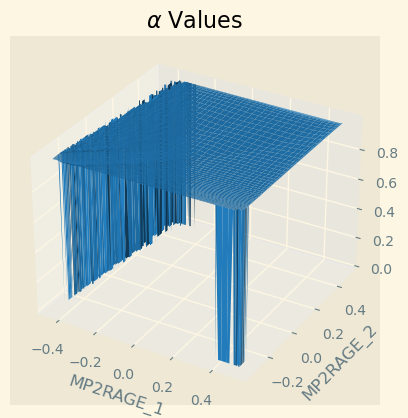

In [37]:
# Relative likelihood
alpha = max_L_gauss/(max_L_gauss + L_uni)

# Plot alpha
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
X,Y = np.meshgrid(mp2rage1, mp2rage2)
ax.plot_surface(X, Y, alpha)
ax.set_xlabel('MP2RAGE_1')
ax.set_ylabel('MP2RAGE_2')
ax.set_zlabel(r'$\alpha$')
ax.set_title(r'$\alpha$ Values')

## Create LUT

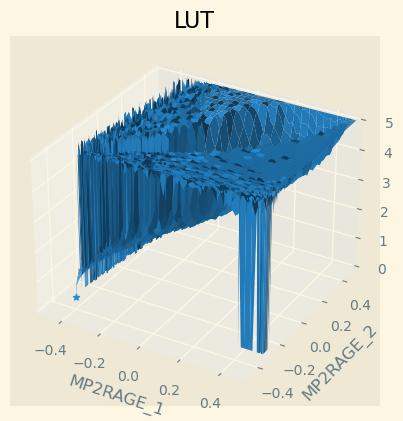

In [31]:
max_L_gauss_ind = np.argmax(posterior, axis=2)
t1_lut = t1_estimate[max_L_gauss_ind]
T = 0.5
# t1_lut[alpha < T] = 0

# Plot LUT
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
X,Y = np.meshgrid(mp2rage1, mp2rage2)
ax.plot_surface(X, Y, t1_lut)
ax.set_xlabel('MP2RAGE_1')
ax.set_ylabel('MP2RAGE_2')
ax.set_zlabel('T1')
ax.set_xlim([-0.5, 0.5])
ax.set_ylim([-0.5, 0.5])
ax.set_zlim([0, 5])
ax.set_title('LUT')

ax.scatter3D(-0.4375, -0.3390, 0, marker='*')

## Calculate T1 map

Text(0.5, 1.0, 'T1 Map (Likelihood)')

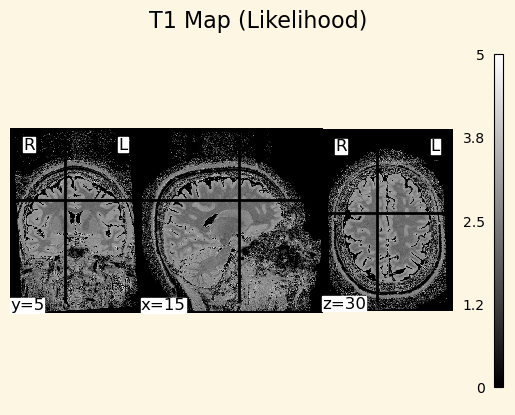

In [ ]:
# Create grid
interp = RegularGridInterpolator((mp2rage1, mp2rage1), values=t1_lut,
    bounds_error=False, fill_value=0, method='linear')

# Interpolate along new values
pts = (t1w1.flatten(), t1w2.flatten())
t1_calc = interp(pts).reshape(t1w1.shape)
t1_calc_nifti = nib.Nifti1Image(t1_calc, subj.affine)

# Plot
fig, ax = plt.subplots()
plotting.plot_img(t1_calc_nifti, cut_coords=(15, 5, 30), cmap='gray', 
    radiological=True, axes=ax, colorbar=True, vmin=0, vmax=5)
ax.set_title('T1 Map (Likelihood)')

## Compare to Marques et al.

Text(0.5, 1.0, 'T1 Map (LUT)')

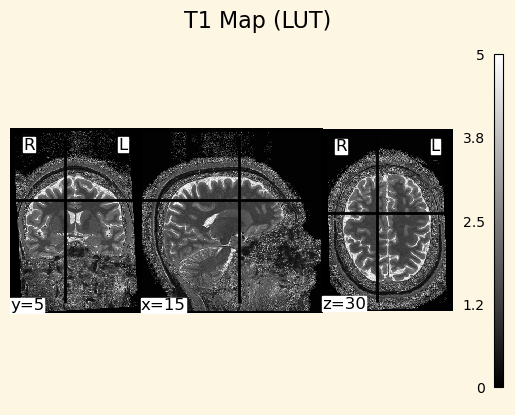

In [ ]:
# Plot T1 map from Marques repo
t1_marques = nib.load('/home/local/VANDERBILT/saundam1/Documents/MP2RAGE-related-scripts/example_t1map2.nii')
t1_marques_data = t1_marques.get_fdata()
fig, ax = plt.subplots()
plotting.plot_img(t1_marques, cut_coords=(15, 5, 30), radiological=True, cmap='gray', axes=ax, colorbar=True, vmin=0, vmax=5)
ax.set_title('T1 Map (LUT)')

RMSE=1.0665771307004586


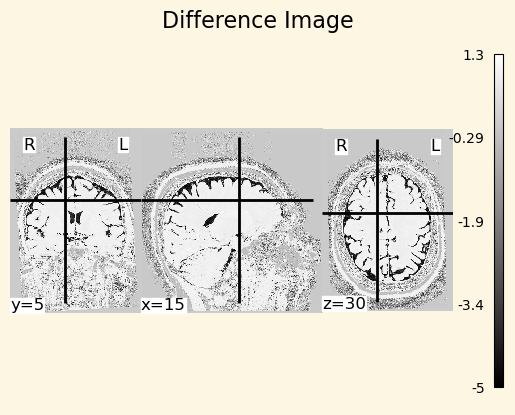

In [ ]:
# Plot difference image
t1_diff = t1_calc - t1_marques_data
t1_diff_nifti = nib.nifti1.Nifti1Image(t1_diff, subj.affine)
fig, ax = plt.subplots()
plotting.plot_img(t1_diff_nifti, radiological=True, cut_coords=(15, 5, 30), cmap='gray', axes=ax, colorbar=True)
ax.set_title('Difference Image')

# Calculate RMSE
t_lin = t1_marques.get_fdata().flatten()
t_calc_lin = t1_calc.flatten()
RMSE = mean_squared_error(t_lin, t_calc_lin, squared=False)
print(f'{RMSE=}')

## Save all NIFTIs

In [ ]:
t1_calc_nifti.to_filename(os.path.join(t1_mapping.definitions.T1_MAPS_LIKELIHOOD, '334264', 't1_map.nii'))
t1_diff_nifti.to_filename(os.path.join(t1_mapping.definitions.T1_MAPS_LIKELIHOOD, '334264', 't1_diff.nii'))
subj.mp2rage[0].to_filename(os.path.join(t1_mapping.definitions.T1_MAPS_LIKELIHOOD, '334264', 'mp2rage_1.nii'))
subj.mp2rage[1].to_filename(os.path.join(t1_mapping.definitions.T1_MAPS_LIKELIHOOD, '334264', 'mp2rage_2.nii'))